In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import predict

dataset=pd.read_csv('SolarRadiationPrediction.csv',engine='python',nrows=576*15)
dataset=dataset.drop("Data",axis=1)
dataset=dataset.drop("Time",axis=1)
# dataset=dataset.drop("TimeSunRise",axis=1)
# dataset=dataset.drop("TimeSunSet",axis=1)
dataset.head(5)


,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,8,2.58,51,30.43,103,77.27,11.25,22020,67080
1,310,2.83,51,30.43,103,153.44,9.00,22020,67080
2,1206,2.16,51,30.43,103,142.04,7.87,22020,67080
3,1505,2.21,51,30.43,103,144.12,18.00,22020,67080
4,1809,2.25,51,30.43,103,67.42,11.25,22020,67080


In [10]:
dataset=dataset.values

In [11]:
dataset[:,1]

array([  2.58,   2.83,   2.16, ..., 344.9 , 365.66, 355.57])

In [12]:
np.random.seed(7)


dataset=dataset.astype('float32')

scalar1=MinMaxScaler(feature_range=(0,1))
scalar2=MinMaxScaler(feature_range=(0,1))
scalar_dim=dataset[:,1]
dataset=scalar1.fit_transform(dataset)

scalar_dim=scalar_dim.reshape(len(dataset),1)
print(scalar_dim)
scalar_dim=scalar2.fit_transform(scalar_dim)
print(scalar_dim)


[[  2.58]
 [  2.83]
 [  2.16]
 ...
 [344.9 ]
 [365.66]
 [355.57]]
[[0.00089369]
 [0.00104993]
 [0.00063121]
 ...
 [0.21482898]
 [0.2278031 ]
 [0.22149728]]


In [13]:
train_size=int(len(dataset)*0.67)
test_size=len(dataset)- train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]

print(train.shape)
print(train)
print(test.shape)
#print(test)

(5788, 9)
[[5.8056499e-05 8.9368853e-04 3.3333325e-01 ... 5.5555558e-01
  0.0000000e+00 1.0000000e+00]
 [3.5646691e-03 1.0499278e-03 3.3333325e-01 ... 4.4444445e-01
  0.0000000e+00 1.0000000e+00]
 [1.3968393e-02 6.3120667e-04 3.3333325e-01 ... 3.8864198e-01
  0.0000000e+00 1.0000000e+00]
 ...
 [1.7786188e-01 4.3747015e-05 2.6666665e-01 ... 2.2222222e-01
  7.1428680e-01 2.9999924e-01]
 [1.8134527e-01 5.6246121e-05 2.6666665e-01 ... 2.7753085e-01
  7.1428680e-01 2.9999924e-01]
 [1.8480544e-01 6.2495703e-05 2.6666665e-01 ... 2.2222222e-01
  7.1428680e-01 2.9999924e-01]]
(2852, 9)


In [14]:
def create_dataset(dataset,look_back):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        #a=dataset第0行i~i+look_back個
        a=dataset[i:(i+look_back),0:9]
        dataX.append(a)
        dataY.append(dataset[i+look_back,1])
    return np.array(dataX),np.array(dataY)

    

In [15]:
#根據前面幾個資料來看下一步 彙整成look_back行的資料
#X用以輸入 Y用用以predict
look_back=5
trainX,trainY=create_dataset(train,look_back)
testX,testY=create_dataset(test,look_back)
print(testX.shape)
#print(testX)
print(testY.shape)
print(trainX.shape)
print(trainY.shape)


(2846, 5, 9)
(2846,)
(5782, 5, 9)
(5782,)


In [16]:
model=Sequential()
#添加的一個 GRU 層。
#這個層有一個名為 4 的參數，這表示該 LSTM 層有 4 個隱藏單元（hidden units）。
# input_shape=(look_back, 1) 則指定了輸入數據的形狀，
# 其中 look_back 是時間窗口的大小，1 表示每個時間步的特徵數。
model.add(GRU(193,activation='tanh',input_shape=(look_back,9)))
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate= 0.082379383823238))
#Dense全連接後輸出一層
model.add(Dense(units=1, activation="linear"))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

model.fit(trainX,trainY,epochs=20,batch_size=1,verbose=2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 193)               118116    
                                                                 
 dense_2 (Dense)             (None, 64)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 130597 (510.14 KB)
Trainable params: 130597 (510.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
5782/5782 - 24s - loss: 0.0067 - 24s/epoch - 4ms/step
Epoch 2/20
5782/5782 - 23s - loss: 0.0050 - 23s/epoch - 4ms/step
Epoch 3/20
5782/

In [17]:
trainPre=model.predict(trainX)
testPre=model.predict(testX)

trainPre.shape
testPre.shape

89/89 [==============================] - 0s 3ms/step


(2846, 1)

In [18]:
trainPre=scalar2.inverse_transform(trainPre)
trainY=scalar2.inverse_transform([trainY])
testPre=scalar2.inverse_transform(testPre)
testY=scalar2.inverse_transform([testY])
print(trainPre.shape)
print(trainY.shape)
print(testPre.shape)
print(testY.shape)


(5782, 1)
(1, 5782)
(2846, 1)
(1, 2846)


In [19]:
print(trainY.shape)
print(trainPre.shape)
print(trainY[0,1])
print(trainPre[1,0])


(1, 5782)
(5782, 1)
2.0699998509781423
-17.26085


In [20]:
#MSE是均方根誤差 即平均誤差 會被平均除下去 所以數據多不代表誤差會增加
trainScore=math.sqrt(mean_squared_error(trainY[0,:],trainPre[:,0]))
print('Train Score:%.2f RMSE'%(trainScore))
testScore=math.sqrt(mean_squared_error(testY[0,:],testPre[:,0]))
print('Test Score:%.2f RMSE'%(testScore))
MAE=mean_absolute_error(testY[0,:],testPre[:,0])
print('Test Score:%.2f MAE'%(MAE))

Train Score:93.98 RMSE
Test Score:103.82 RMSE
Test Score:51.55 MAE


In [21]:
print(trainY[0,:])
print(trainPre[:,0].shape)

[2.15000019 2.06999985 2.05999993 ... 1.23999998 1.22000004 1.23999998]
(5782,)


In [22]:
trainPredictplot=np.empty_like(scalar_dim)
#print(trainPredictplot)
trainPredictplot[:,:]=np.nan
#print(trainPredictplot)
trainPredictplot[look_back:len(trainPre)+look_back,:]=trainPre
print(trainPredictplot)
print(trainPredictplot.shape)

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
(8640, 1)


In [23]:
testPredictPlot=np.empty_like(scalar_dim)
testPredictPlot[:,:]=np.NaN
testPredictPlot[len(trainPre)+(look_back*2)+1:len(dataset)-1,:]=testPre
print(testPredictPlot)

[[      nan]
 [      nan]
 [      nan]
 ...
 [229.27707]
 [317.7648 ]
 [      nan]]


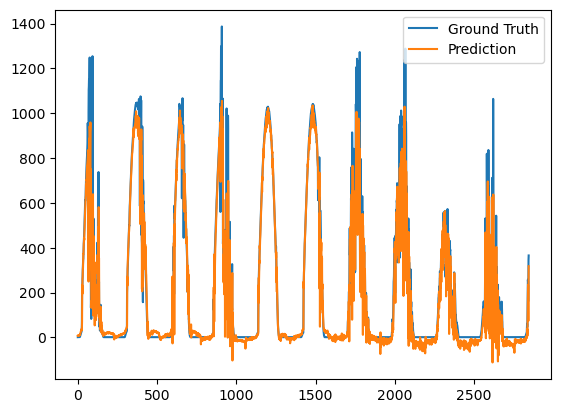

In [24]:
ground_truth=scalar2.inverse_transform(scalar_dim)
plt.plot(testY[0,:],label='Ground Truth')
#plt.plot(trainPredictplot,label='Prediction(training)')
plt.plot(testPre[:,0],label='Prediction')
plt.legend()
plt.show()

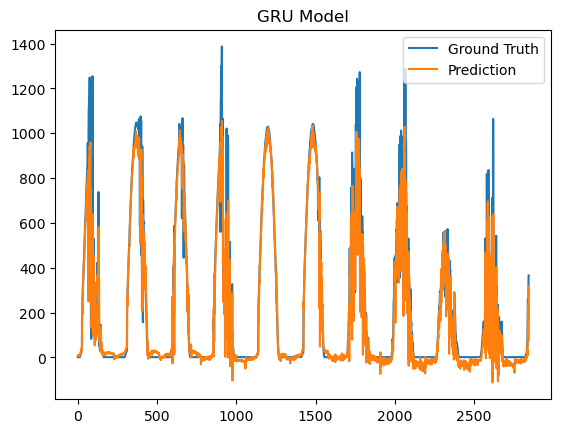

MAE: 51.55
RMSE: 103.82
R2 Score: 0.9
MAE: 51.55
RMSE: 103.82
R2 Score: 0.9
MAE: 51.55
RMSE: 103.82
R2 Score: 0.9


<Figure size 640x480 with 0 Axes>

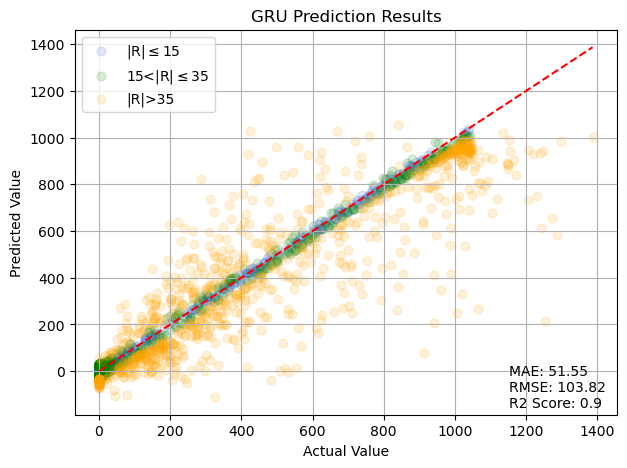

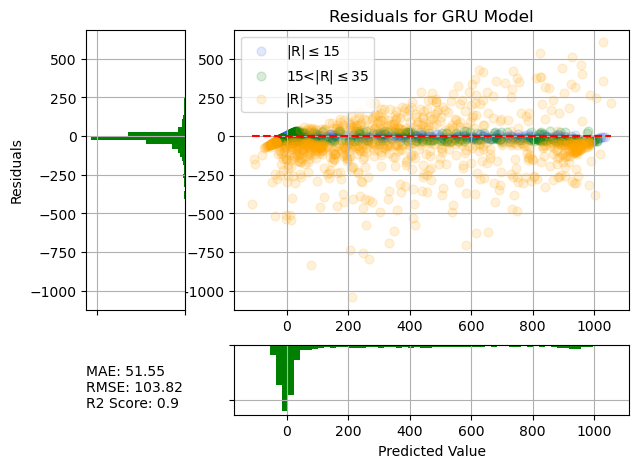

In [25]:
predict.my_self(testY[0,:],testPre[:,0],'GRU')
predict.score_calculation(testY[0,:],testPre[:,0])
predict.plot_pred(testY[0,:],testPre[:,0],'GRU')
predict.plot_residuals(testY[0,:],testPre[:,0],'GRU')
